In [ ]:
from IPython.display import clear_output 
!pip install datasets
!pip install transformers
!pip install tokenizers
!pip install knlm
clear_output()

![url[1]](https://www.cambiumassessment.com/-/media/project/cambium/corporate/images/cambium-logos/cambium-logo-duo-horz.svg?h=100&iar=1&w=366&hash=C00906A955D72F21062086CF7A5CF77E)


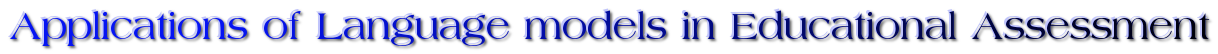


---

**Presenters:**

---

**Christopher Ormerod**, *Principle Mathematician at Cambium Assessment*

**Amir Jafari**, *Lead Data Scientist at Cambium Assessment*

**Sue Lottridge**, *Senior Director of Automated Scoring at Cambium Assessment*

---

This notebook was prepared for the training course delivered at NCME 2022.

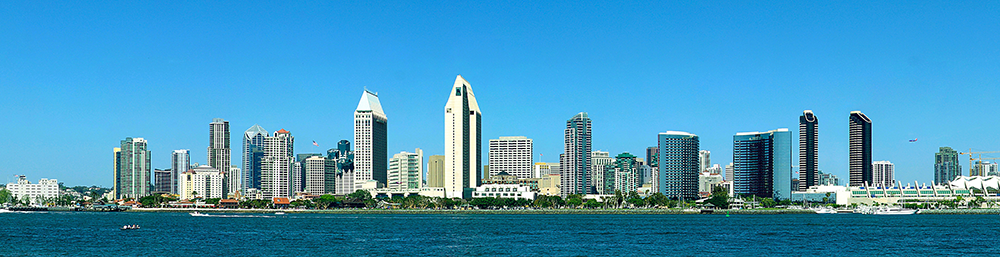

---

We start this session by installing a collection of the necessary libraries for this notebook. These inlcude 
- [Huggingface Datasets](https://github.com/huggingface/datasets)
- [Huggingface Transformers](https://github.com/huggingface/transformers)
- [Huggingface Tokenizers](https://github.com/huggingface/tokenizers)
- [Kneser-Ney Language models](https://pypi.org/project/knlm/)

In addition to these, we will be using the following preinstalled libraries:
- [NumPy](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/)
- [Scikit-learn](https://scikit-learn.org/stable/)
- [SciPy](https://scipy.org/)
- [PyTorch](https://pytorch.org/)
- [matplotlib](https://matplotlib.org/)
- [Gensim](https://radimrehurek.com/gensim/)
- [Natural Language Toolkit](https://www.nltk.org/)

---

[Section 1: Machine Learning](#sec1)

[Section 2: Sci-kit-learn, pandas and BoW models](#sec2)

[Section 3: Language Models](#sec3)

[Section 4: Pytorch and Neural Networks](#sec4)

[Section 5: Recurrent Neural Networks](#sec5)

[Section 6: Language Models](#sec6)

This notebook was prepared for the training course delivered at NCME 2022.

---
---
---

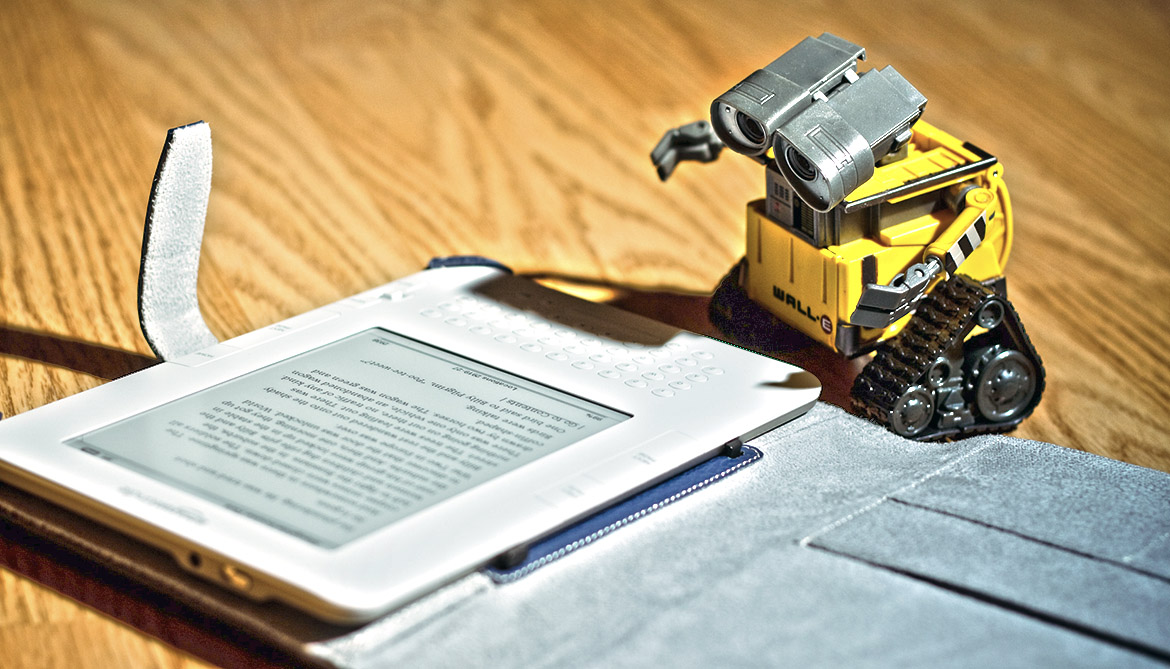

**Section 1 : Machine Learning** <a name="sec1"></a>


---


Machine learning is the study of models that automatically improve by using data. 

The libraries we will require for this section are imported below.

In [ ]:
import numpy as np
from scipy import optimize
from scipy.special import softmax
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt



---


Let us demonstrate the basics of machine learning with a simple dataset. Let us first create two sets of points, one normally distributed around the point (1,0) and another around (-1,0). The matrix X contains all these points with the first set labelled by 0's and the other labelled by 1's. 

We do this using np.random.multivariate:

In [ ]:
X1 = np.random.multivariate_normal([1,0], [[1,0],[0,1]], 500)
X2 = np.random.multivariate_normal([-1,0], [[1,0],[0,1]], 500)
X = np.concatenate([X1,X2],0)
y = np.concatenate([np.zeros(500),np.ones(500)])

We can visualize the points using matplotlib using the scatter function: 

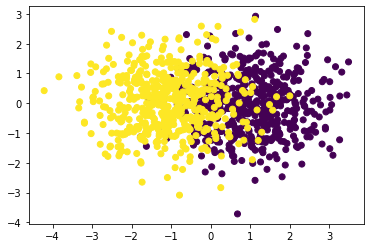

In [ ]:
plt.scatter(X[:,0],X[:,1],c=y)

Let us set up the problem of dividing these two sets of points. We start by defining the $\sigma$ function:

\\

$\sigma(x) = \frac{1}{1-e^{-x}}$

\\

and we let $f(x)$ be our prediction function for our points $(x_0,x_1) \in \mathbb{R}^2$, it is parameterized by a point $a = (a_0,a_1,a_2) \in \mathbb{R}^3$

\\

$f(a, x) = \sigma(a_0 x_0 + a_1 x_1 + a_2)$

\\

Our predictions are $0$ if $f(a,x) < \frac{1}{2}$ and $1$ if $f(a,x) > \frac{1}{2}$, but as a continuous function, we can simply compute the difference between the labels and the function $f(x)$. So given a value of $a$, a point $x$ and a label $y \in \{0,1\}$, we calculate the distance

\\

$d(a,x,y) = |f(a,x) - y|$,

\\

Our loss function is the total difference over all points and their labels:

\\

$L = \sum_{x,y} d(a,x,y)$

\\

In [ ]:
f = lambda a,x:sigmoid(a[0]*x[0]+a[1]*x[1] + a[2])
dist = lambda a,x,y: np.abs(f(a,x) - y)
loss = lambda a:sum([dist(a,x,y) for x,y in zip(X,y)])

The loss function is simply a function of $a$ only, so what we need is to minimize $L$ with respect to $a$.

\\

$a_{optimal} = \mathrm{argmax}_{a} L(a)$

\\

**Disclaimer**: Calling the minimize function as we have done here is almost never done in practice. We are using this as a tool to demonstrate the principles of machine learning.  

In [ ]:
res = optimize.minimize(loss, [-10,0,1])

The value of this parameter, $a$, is held within the res['x'] variable. We can now test whether this parameter looks reasonable. We do this by checking out $f(a,x)$ for each point, whether $f(a,x) > 0.5$ or $f(a,x) < 0.5$. These are the predictions. 

In [ ]:
pred_class =[0 if f(res['x'], x) < 0.5 else 1 for x in X]

Visualizing this result gives us the following:

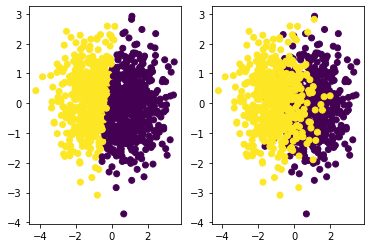

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(X[:,0],X[:,1],c=pred_class)
ax2.scatter(X[:,0],X[:,1],c=y)

On the left we have the predicted class, on the right we have the actual class.

\\

Ultimately, we want to know how successful this division is. The metric we use is the accuracy; the ratio of correctly labelled to total number of results. This can be calculated as follows: 

In [ ]:
correct = sum([int(y_true)==int(pred) for y_true,pred in zip(y,pred_class)])
print(correct/len(y))

0.869


Unfortunately, this is cheating! What we really want to know is how well this classification works for new items, those that the loss function has not "seen".

\\

The "correct" thing to do is to make sure that the method you use has not seen the data you are validating on. To do this, we split the data into a training set, and a testing set. The loss function is only calculated on the training set and tested on the test set.

\\

We start by defining which indices should be in the training set and which indices should be in the test set.

In [ ]:
train_indices = np.random.choice(range(1000), size=750, replace=False)
test_indices = [x for x in range(1000) if x not in train_indices]

From this, we define $X_{train}, X_{test}$ which are associated with labels $y_{train}, y_{test}$. 

In [ ]:
X_train, y_train = np.stack([X[i] for i in train_indices],0), [y[i] for i in train_indices]
X_test, y_test = np.stack([X[i] for i in test_indices],0), [y[i] for i in test_indices]

Now the new loss function is calculated only over the training set:

In [ ]:
loss = lambda a:sum([dist(a,x,y) for x,y in zip(X_train,y_train)])
res = optimize.minimize(loss, [-10,0,1], method="Powell")

In particular, now we can calculate the accuracy on the unseen test set. 

In [ ]:
pred_class =[int(np.round(f(res['x'], x))) for x in X_test]
correct = sum([int(y_true)==int(pred) for y_true,pred in zip(y_test,pred_class)])
print(correct/len(y_test))

0.856


We can visually see the difference between the actual labels and the 

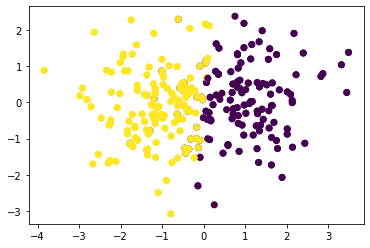

In [ ]:
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)
plt.scatter(X_test[:,0],X_test[:,1],c=pred_class)

When we turn to a three class classification, where we define 900 points, each point in the classes 0,1, or 2. This time the data is centered around the points (1,0), (-1,0) and (0,2) with the same distributions as the previous cases. 

\\

We set this data up as follows: For this experiment we want three groups of points centered at

In [ ]:
X1 = np.random.multivariate_normal([2,0], [[1,0],[0,1]], 300)
X2 = np.random.multivariate_normal([-2,0], [[1,0],[0,1]], 300)
X3 = np.random.multivariate_normal([0,3], [[1,0],[0,1]], 300)
X = np.concatenate([X1,X2,X3],0)
y = np.concatenate([np.zeros(300),np.ones(300),2*np.ones(300)])

Let us visualize these points as a sanity check.

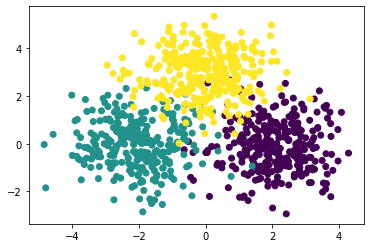

In [ ]:
plt.scatter(X[:,0],X[:,1],c=y)

A simple way to set up the loss function is to let 

\\

$X_t = (X|1)$

\\

where we have appended the value 1 to each row. Now we use a $3\times3$ matrix $A$ to parameterize the sigmoid function and 

\\

$f(A, x) = \mathrm{Softmax}(x A)$

\\

where $\sigma$ is applied to each element. The result is an element of $\mathbb{R}^3$ and the targets are the values $y = (1,0,0)$, $(0,1,0)$, and $(0,0,1)$, which is a one-hot-encoding of the labels. The loss function is the sum

\\

$L(A) = \sum_{x,y} |f(A, x) - y|^2$

\\

Note: the function optimize expects a one dimensional vector, not a matrix, so the loss function will reshape a 9-dimensional vector into a $3 \times 3$ matrix.

This is coded as follows:

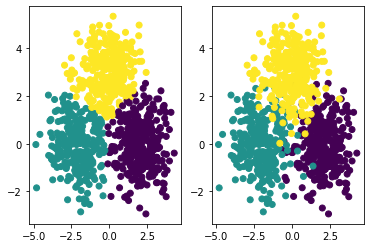

In [ ]:
Y = np.concatenate([[[1,0,0] for _ in range(300)],[[0,1,0] for _ in range(300)],[[0,0,1] for _ in range(300)]])
# This forms the one-hot-encoding for the targets

A0 = np.random.random(9)
Xt = np.concatenate([X,np.ones((900,1))],1)
# Xt = (X|1)

loss = lambda A:sum(sum((softmax(np.matmul(Xt,A.reshape((3,3))))-Y)**2))
# L(A) = \sum |\sigmoid (X_t x A) - Y|^2

res = optimize.minimize(loss, A0)
Ap = res['x'].reshape((3,3))

# Now Ap contains the entries for the
pred_class = np.argmax(sigmoid(np.matmul(Xt,Ap)),1)

# We now plot the predictions on the left, the original classes on the right
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(X[:,0],X[:,1],c=pred_class)
ax2.scatter(X[:,0],X[:,1],c=y)

Now we can measure the accuracy

In [ ]:
accuracy_score(y,pred_class)

0.9444444444444444

Note: Due to the random initial conditions, it is possible for this algorithm to not converge.

---
---
---

**Excercises**

1. Peform a test-train split of the data directly above to get a better estimate of the performance on an unseen set.
2. Modify the loss function to use the absolute value of the difference instead of the square of the difference. 
3. Some minimization algorithms (such as BGFS) require the Jacobian to be defined. Determine the Jacobian of the MSE loss function,

    $J = [ \frac{\partial L}{\partial a_0}, \ldots, \frac{\partial L}{\partial a_n}]$.

4. Define the Jacobian as a function of $a$.
5. Use the BGFS method of optimization by adding the keyword argument "method = "BGFS" and using the Jacobian defined in section 4. 

---
---
---

***Section 2:Sci-kit-learn, Pandas, and BoW*** <a name="sec2"></a>

---



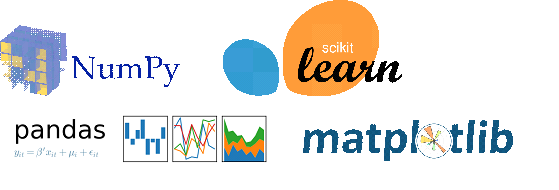

Pandas and sci-kit learn are two libraries that make it easy to import, select, save and apply machine learning techniques to data.  

The libraries we will require for this section are imported below.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, 
                             cohen_kappa_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datasets import load_dataset
from collections import Counter

smd = lambda x,y: np.abs(np.mean(x) - np.mean(y))/np.sqrt((np.std(x)**2+np.std(y)**2)/2)

---

The goal of this section is to familiarize the participant with some of the standard tools used to perform some standard machine learning methods such as


*   Logistic Regression
*   Random Forest
*   K-means

In addition to this, we introduce some basic pandas functionality that will allow us to save and load data, and select data with respect to certain characteristics.


---

We start by defining some data, so that we can demonstrate how the various methods work. 

We start with data that is similar to the last part of the previous section: three sets of points normally distributed around the points (1,0), (-1,0) and (0,2), each in the classes 0,1 and 2.

In [ ]:
X1 = np.random.multivariate_normal([1,0], [[1,0],[0,1]], 300)
X2 = np.random.multivariate_normal([-1,0], [[1,0],[0,1]], 300)
X3 = np.random.multivariate_normal([0,2], [[1,0],[0,1]], 300)
X = np.concatenate([X1,X2,X3],0)
y = np.concatenate([np.zeros(300),np.ones(300),2*np.ones(300)])

This time we use the train_test_split function to partition our data into a training set and a test set. 

Now instead of implementing a loss function from scratch, we use the LogisticRegression library. The implementation is a little different from above in that we distinguish a coefficient matrix, $A$, and a bias term, $b$, so that if the points were in a matrix $n \times 2$ matrix, then $A$ is a $3 \times 2$ matrix, $b \in \mathbb{R}^3$, and the function is

\\

$L(X) = \sigma(A X^t  + b)$

\\

It is fast (written in C), simple, and much more stable. Given an array with rows in a matrix X, whose targets for each row is in an array, y, we simply call the fit method:

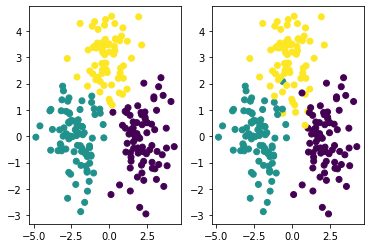

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf = LogisticRegression()
clf.fit(X_train, y_train)
# At this point, the coefficients 

y_pred = clf.predict(X_test)

# We now plot the predictions on the left, the original classes on the right
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X_test[:,0],X_test[:,1],c=y_pred)
ax2.scatter(X_test[:,0],X_test[:,1],c=y_test)

The coefficients we derived in the first section from first principles can be found by looking at the variables stored inside the classifier object. Namely, the matrix and bias terms can be exposed by accessing the coef_ and intercept_ variables.

In [ ]:
# The nine values are the 2x3 matrix AX+b
print(clf.coef_)
print(clf.intercept_)

[[ 1.62948308 -0.94378574]
 [-1.61196247 -0.91405476]
 [-0.01752062  1.85784051]]
[ 0.91193508  0.8230574  -1.73499247]


Let us compare the accuracy of the logistic regression, Random Forest, and a K-means clustering algorithm:

In [ ]:
for classifier in []

In [ ]:
print(accuracy_score(y_pred, y_test))
print(cohen_kappa_score(y_pred, y_test, weights="quadratic"))
print(smd(y_pred,y_test))

0.9688888888888889
0.9342074888037306
0.02774525610548873


Since each classifier has the same set of functions, we can compare different classifiers.

In [ ]:
from sklearn.ensemble import DecisionTreeClassifier

ImportError: ignored

In [ ]:
for classifier in [RandomForestClassifier, 
                   DecisionTreeClassifier,
                   LogisticRegression,
                   GaussianNB]:
  clf = classifier()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classifier)
  print("Accuracy : {:.2f}\%".format(100*accuracy_score(y_pred, y_test)))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy : 60.444\%
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy : 57.778\%
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy : 73.778\%
<class 'sklearn.naive_bayes.GaussianNB'>
Accuracy : 73.333\%


A Bag of Words classifier is a word frequency-based 

In [ ]:
train_data = load_dataset("imdb", split="train")
test_data = load_dataset("imdb", split="test")
clear_output()

In [ ]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

The first question we need to ask is whether the data is balanced. So we apply a Counter to the labels to see that the total number of positive and negative reviews is exactly balanced.

In [ ]:
print(Counter(train_df['label']))
print(Counter(test_df['label']))

Counter({0: 12500, 1: 12500})
Counter({0: 12500, 1: 12500})


The TF-IDF vectorizor is a standard class within sklearn. The class streamlines the process of taking the frequency data, and the inverse document frequency data into one transformation. That data has a single row for each datapoint (text) and a single dimension for every single word used in the database. Latent Semantic Analysis is an unsupervised method that performs a singular value decomposition of the TF-IDF matrix to form the most useful information in formulating a classificaiton. That unsupervised method highlights a fixed feature vector respresentation of the text which is the basis for a classification.

In [ ]:
vect = TfidfVectorizer()
Z_train = vect.fit_transform(train_df['text'])
Z_test = vect.transform(test_df['text'])
y_train = train_df['label']
y_test = test_df['label']

clf = LogisticRegression()
clf.fit(Z_train, y_train)
y_pred = clf.predict(Z_test)

LSA = TruncatedSVD(n_components=300)
X_train = LSA.fit_transform(Z_train)
X_test = LSA.transform(Z_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Once we have a set of predictions, we need to know how to evaluate the model. 

There are guidelines on how this evaluaiton is done. In particular, in the field of assessment, we have three main metrics to compare models:

* Accuracy. This is also called "exact match".

* Quadratic weighted kappa:

$\kappa = 1 - \frac{\mathbb{E}(|X_1 - Y_1|^2)}{\mathbb{E}(|X_1 - Y_2|^2)}$.

* Standardized Mean Difference

$SMD = \frac{|\mu(Y_1) - \mu(Y_2)|}{\frac{1}{2}(\sigma(Y_1) + \sigma(Y_2))}$


In [ ]:
print(accuracy_score(y_pred, y_test))
print(cohen_kappa_score(y_pred, y_test))
print(smd(y_pred, y_test))

0.86852
0.7370399999999999
0.015280891965584232


The accuracy on this test run was 86.9%, the QWK was 0.737 and the SMD was 0.015. Due to the simplicity and generally decent results, models such as these often define a baseline to compare more sophisticated models.

---
---
---

**Excercises**


1.   Determine whether positive reviews are generally longer or shorter than negative reviews. What other characteristics about the reviews could be checked?
2.   The Logistic Regression can be used to formulate probabilities (predict_proba) of each review being positive of negative. Use this to determine which reviews are most negative and most positive in the set. 
3.   Determine a set of 10 reviews that are the most contentious (i.e., these are reviews with probabilities that are closest to 0.5).
4.   Are positive reviews 



---
---
---

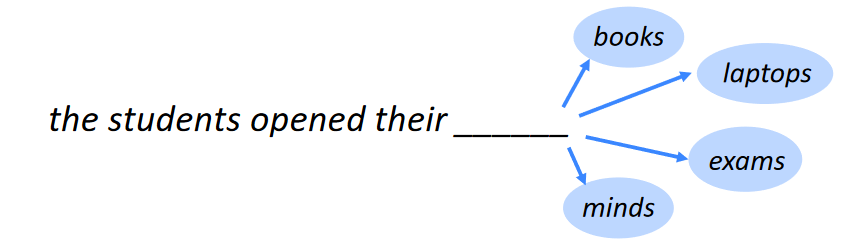

**Section 3 : Language Models** <a name="sec3"></a>

---


Many language models are based on n-gram information. The most basic of these are n-gram models, however, these models do not generalize well, even on data very similar to the training data. We will look at these more classical models as a way to effectively gauge the similarity between a text and some training data.

The libraries we will require for this section are imported below.

---



In [ ]:
from nltk import ngrams
import numpy as np
from nltk.tokenize import RegexpTokenizer
from datasets import load_dataset
from collections import Counter
import gensim
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers

---

The first thing we do is fix a tokenization. Our goal is to have a tokenization that is fast, so we use a fairly simple regular expression. 

*Note: There are many more accurate tokenizations that SpaCy and NLTK offer that are more accurate, but they also tend to be slower.*

In [ ]:
tokenizer = RegexpTokenizer(pattern=r'\w+|\$[\d\.]+|\S+')
student_dataset = load_dataset("NahedAbdelgaber/evaluating-student-writing",split='train')
clear_output()

It is now a matter of concatenating the data and finding the set of all n-grams. We use NLTK to do this.

In [ ]:
all_text = ' '.join(student_dataset['text']).lower()
words = tokenizer.tokenize(all_text)
data = ngrams(words,n=3)

We use the Counter function to obtain the frequency of each n-gram. <a name="countdata"></a>

In [ ]:
counts = Counter(data)

Using this data, we can generate text randomly based on the trigrams that appear. Given the two previous words, $w_1$ and $w_2$, the probability of the next word being $v$ is

\\

$$P(w_1w_2v) = \frac{f(w_1w_2v)}{f(w_1w_2)} = \frac{f(w_1w_2v)}{\sum_{u \in V} f(w_1w_2u)}$$

\\

We store the intermediate information, the frequencies of $f(u) = f(w_1w_2u)$, in the my_counts variable and use this to define probability weights in the random choice function. The list is of all elements, $v$, appearing as a trigram $w_1w_2v$, and the weight is $f(v)/\sum_u(f(u))$.

\\

Secondly, given two words that appear in a trigram, we can define a generate function that uses the random function to generate a next word. This can be done iteratively to create a text that should approximate student writing. <a name="generate"></a>

In [ ]:
def random_next(word1, word2):
  my_counts = {x:v for x,v in counts.items() if word1 == x[0] and word2 == x[1]}
  return np.random.choice([x[2] for x in my_counts],p=[x[1]/sum(my_counts.values()) for x in my_counts.items()])

def generate(text, k):
  tokens = tokenizer.tokenize(text)
  for i in range(k):
    tokens.append(random_next(tokens[-2],tokens[-1]))
  return ' '.join(tokens)

In [ ]:
generate("i am",100)

'i am trying to collect data from more than one opinion can help students keep learning . by doing so , your governor prepares a "certificate of ascertainment also declares the winner of all , four automotive radar sensors , a project on the road becasue they are so many crashes there be a choice . some may argue that students will benefit from being able to drive themsleve and to them because life is actually driverless , automatic car would turn out afterwords . this is a good place to examine it . if the driver when the whole class when'

This gives us another capability of language models; to generate text. The main problem is that seemingly common bigrams may not have a corresponding trigram simply because this corpus is not large. For example, you could expect a sentence like "A train can pull large amounts of cargo", yet our corpus had no instances of the words "train can". The following will result in an error:

In [ ]:
random_next("train","can")

ValueError: ignored

One of the ways to get around this is by creating language models that ever so slightly shifting the frequencies from all the n-grams seen in the training sample to those that have not been seen. We do this by using a constant discount. To approximate this discount, assume that we split our data into two equal sets; a training set and a testing set. 

In [ ]:
train, test = train_test_split(student_dataset['text'], test_size=0.5)

train_text = ' '.join(train).lower()
test_text = ' '.join(test).lower()

train_words= tokenizer.tokenize(train_text)
test_words= tokenizer.tokenize(test_text)

T1 = Counter(train_words) 
T2 = Counter(test_words)

Above, we have two counters; the frequency of words in the training set is denoted T1, while T2 holds the frequencies in the test set. On average, if the word appears $k$ times in the training set, it appears $k-\delta$ times in the test set. 

In [ ]:
words = lambda i:{w:k for w,k in T1.items() if k==i}
{i:np.mean([T2[w] for w in words(i)]) for i in range(1,10)}

{1: 0.4383943269596049,
 2: 1.398005085077254,
 3: 2.3111553784860557,
 4: 3.3775372124492558,
 5: 4.320699708454811,
 6: 5.507265521796565,
 7: 6.248796147672552,
 8: 7.016460905349795,
 9: 8.33242506811989}

We can average over the first 30 elements to find a reasonable approximation for $\delta$. 

In [ ]:
words = lambda i:{w:k for w,k in T1.items() if k==i}
np.mean([i-np.mean([T2[w] for w in words(i)])  for i in range(1,30)])

0.6169955288948489

The Knesey-Ney model has some assumptions that there is a minimal probability of words appearing. It assumes the discount above in addition to some extra assumptions. If the frequency data function f is as above, then for bigrams, we have

\\

$$p(w_{n-1}w_n) = \frac{\max(f(w_{n-1}w_n) - \delta,0)}{f(w_{n-1})} + \lambda_{w_{n-1}} \frac{|\{u: f(u w_n) > 0\}|}{|\{(u,v) : f(uv) > 0\}|}$$

$$=\frac{\max(f(w_{n-1}w_n) - \delta,0)}{f(w_{n-1})} + \delta \frac{|\{u:f(w_{n-1}u) > 0\}|}{f(w_{n-1})}.$$

\\

This is a proper distribution in which the sum of probabilities is 1. The $\lambda$ term ensures that the probability of $n$-grams not seen is non-zero, whch has the effect of smoothing out bigrams that may not have appeared due to data sparsity.

This extends to n-grams recursively:

\\

$$p(w_{1}\ldots w_n) = \frac{\max(f(w_{1} \ldots w_n) - \delta, 0)}{f(w_1\ldots w_{n-1})} + \delta \frac{|\{ u : f(w_1\ldots u) > 0\}|}{f(w_1\ldots w_{n-1})} p(w_2\ldots, w_n)$$

\\

To implement this model, there are a variety of library choices. While the standard library for these models is <a href="https://github.com/kpu/kenlm">kenlm</a>, for the purposes of this demonstration, we use <a href="https://pypi.org/project/knlm/">this library</a>. The training and evaluation are shown below: 

In [ ]:
from knlm import KneserNey
mdl = KneserNey(3, 4)
for x in text_dataset['text']:
  mdl.train(tokenizer.tokenize(x.lower()))

A simple way to test our model is to see the results of changing between single words that are known to be less likely. The output of the model is the log-probabilities:

In [ ]:
print(mdl.evaluateSent("i like to drink a nice cup of coffee .".split()))
print(mdl.evaluateSent("i like to drink a nice cup of syrup .".split()))

NameError: ignored

**Embeddings**

Another form of language modelling is the mapping of words into a vector space, also known as a semantic space. There are two common types of embedding; skip-gram and continuous bag of words (CBOW). The difference between them is that they are simple neural networks that seek to either predict the context of a single word (skip-gram) or approximate a word given its context (CBOW). Both models endow a representation with semantic relations in which similar words are mapped to vectors with high cosine similarity, and the differences between related classes of words are more or less constant.

We use the gensim library to model words. The input into a model is a list of tokenized texts. I.e., we expect an iterable containing lists of words. 

In [ ]:
import gensim
import gensim.downloader as api
import pandas as pd

In [ ]:
model = gensim.models.Word2Vec([tokenizer.tokenize(x.lower()) for x in text_dataset['text']], size=50)

In [ ]:
model.most_similar('smart')

In [ ]:
from datasets import load_dataset

train_data = load_dataset("imdb", split="train")
test_data = load_dataset("imdb", split="test")
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


In [ ]:
model.most_similar("smart")

L = ["bread","cheese","food","animals","meat"]
model.predict_output_word(context_words_list=L, topn=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('animals', 0.009061264),
 ('feed', 0.004780698),
 ('food', 0.003306518),
 ('horses', 0.0030136276),
 ('cross', 0.0026348762),
 ('335', 0.0025118187),
 ('cattle', 0.0021282148),
 ('supplies', 0.002107184),
 ('water', 0.0020791648),
 ('boat', 0.0017185798)]

In [ ]:
def avg_embed(text):
  words = [x for x in tokenizer.tokenize(text.lower())]
  X = np.stack([model.wv[x] for x in words if x in model.wv])
  return X.mean(0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             cohen_kappa_score)
smd = lambda x,y: np.abs(np.mean(x) - np.mean(y))/np.sqrt((np.std(x)**2+np.std(y)**2)/2)

X_train = train_df['text'].map(avg_embed).apply(pd.Series)
X_test = test_df['text'].map(avg_embed).apply(pd.Series)

clf = RandomForestClassifier()
clf.fit(X_train, train_df['label'])
y_pred = clf.predict(X_test)

print(cohen_kappa_score(y_pred, train_df['label'], weights="quadratic"))
print(accuracy_score(y_pred, train_df['label']))

0.41735999999999995
0.70868


In [ ]:
print(cohen_kappa_score(y_pred, train_df['label'], weights="quadratic"))
print(accuracy_score(y_pred, train_df['label']))

0.42247999999999997
0.71124


**Subwords**

Tokenization typically has been either done at the character level or the word level. At the character level, we often find it much more difficult to ascertain semantic information, however, systems tend to be more robust to mispelling. At the word level, we have semantic information, but mispellings are not well treated without very accurate normalizing preprocessing. Secondly, due to word sparsity, we often miscalculate the word level semantics. 

To define a wubword tokenization, the tokenizers library has a collection of subword tokenization algoirthms, these include


*   Word Level
*   Unigram
*   WordPiece
*   BPE

Given a corpus, each is a variation on the subword tokenization that optimizes how the words in the corpus are broken up into a fixed number of subword tokens. 

In [ ]:
tokenizer = Tokenizer(models.Unigram())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoder = decoders.ByteLevel()

trainer = trainers.UnigramTrainer(
    vocab_size=5000,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    special_tokens=["<PAD>", "<BOS>", "<EOS>"],
)
tokenizer.train_from_iterator(student_dataset['text'], trainer=trainer)

---
---
---

**Exercises**
1. Using the count data from [above](#countdata), define a different [generate](#generate) function that returns the most likely word instead of a random word. 

---
---
---

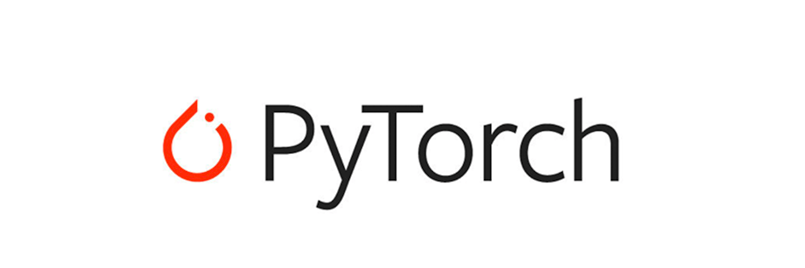

**Section 4 : Pytorch and Neural Networks** <a name="sec4"></a>

---

Pytorch is a library that is used to define, train, and apply neural networks. 

The libraries we will require for this section are imported below.

In [ ]:
import torch
import numpy as np
from torch import nn
from datasets import load_dataset
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers
from tqdm import tqdm
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

---

First of all, what is a neural network. 

In [ ]:
student_dataset = load_dataset("NahedAbdelgaber/evaluating-student-writing",split='train')
tokenizer = RegexpTokenizer(pattern=r'\w+|\$[\d\.]+|\S+')
all_text = ' '.join(student_dataset['text']).lower()
words = tokenizer.tokenize(all_text)
data = ngrams(words,n=5)

Using custom data configuration NahedAbdelgaber--evaluating-student-writing-58d09cfcfdfacc46
Reusing dataset text (/root/.cache/huggingface/datasets/text/NahedAbdelgaber--evaluating-student-writing-58d09cfcfdfacc46/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


In [ ]:
vocab = list(set(words))
vocab_size = len(vocab)
word2idx = {vocab[i]:i for i in range(vocab_size)}
idx2word = {i:vocab[i] for i in range(vocab_size)}

In [ ]:
Z = np.zeros(vocab_size)

In [ ]:
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = deepcopy(Z)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

The stucture of the continuous bag of words has essentially two linear layers; one that maps to the finite dimensional embedding space and another to determine the output.

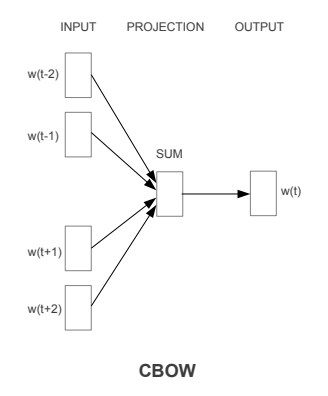

As a model, we can use a linear layer whose input is the size of the vocabulary and output is the size of the desired dimension, while the second linear layer does the opposite. We also include an activation function, the softmax function, so that the output can be interpreted as probabilities (more or less), which will allow for the use of the MSE Loss function.

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(vocab_size , hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size )
        self.act1 = torch.nn.Softmax(dim=1)
    def forward(self, x):
        out_em = self.linear1(x)
        output = self.linear2(out_em)
        output = self.act1(output)
        return out_em, output

One we have defined our module, input, output, loss function, and optimizer, it is time to run the code. 

**Note**: The below code is not optimized, hence, we will not expect it to converge very quickly. 

In [ ]:
model = MLP(2,vocab_size)
critereon = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-2)

data = ngrams(words,n=5)
X_batch = []
y_batch = []

qbar = tqdm(data)
for fivegram in qbar:
  for word in [fivegram[i] for i in [0,1,3,4]]:
    y = to_one_hot_encoding(word2idx[fivegram[2]])
    X = to_one_hot_encoding(word2idx[word])
    X_batch.append(X)
    y_batch.append(y)
    if len(X_batch) ==2000:
      optimizer.zero_grad()
      X_tensor = torch.tensor(np.stack(X_batch)).float()
      y_tensor = torch.tensor(np.stack(y_batch)).float()
      X_tensor.requires_grad=True
      embed, y_pred = model(X_tensor)
      loss = critereon(y_pred, y_tensor)
      loss.backward()
      optimizer.step()
      X_batch = []
      y_batch = []
      qbar.desc = "Loss:{}".format(float(loss))

**Toy Example**

The corpus above is large for a process that is not well optimized. To demonstrate the principles for a much smaller corpus, we create a much smaller set of sentences with a smaller more managable vocabulary. 

In [ ]:
corpus = ['a king is a strong man',
          'a queen is a wise woman',
          'a boy is a young man',
          'a girl is a young woman',
          'a prince is a young king',
          'a princess is a young queen',
          'a man is strong',
          'a woman is pretty',
          'a prince is a boy will be king',
          'a princess is a girl will be queen']

In this example, we will remove all stop words, which is a common practice in topic modelling. 

In [ ]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        tmp = [x for x in tmp if x not in stop_words]
        results.append(" ".join(tmp))

    return results

In [ ]:
corpus = remove_stop_words(corpus)

The sentences above are simple enough to be tokenized by the split function, which simply assumed all words are separated by spaces. This simplifies the calculation. 

In [ ]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())

words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)
print(words)

{'young', 'prince', 'princess', 'boy', 'girl', 'woman', 'pretty', 'strong', 'wise', 'king', 'queen', 'man'}


In [ ]:
sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

We only have 

In [ ]:
word2int = {}
for i, word in enumerate(words):
    word2int[word] = i

In [ ]:
WINDOW_SIZE = 2
data = []

for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0): min(idx + WINDOW_SIZE, len(sentence)) + 1]:
            if neighbor != word:
                data.append([word, neighbor])
df = pd.DataFrame(data, columns = ['input', 'label'])

In [ ]:
vocab_size = len(words)
Z = np.zeros(vocab_size)
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = deepcopy(Z)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding
# -------------------------------------------------------------------------------------
X = []
Y = []
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [ ]:
model = MLP(2, vocab_size)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-2)

In [ ]:
p = torch.Tensor(X_train)
p.requires_grad = True
t = torch.Tensor(Y_train)

In [ ]:
for epoch in range(20000):
    optimizer.zero_grad()
    _, t_pred = model(p)
    loss = criterion(t, t_pred)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print("Epoch {} | Loss {:.5f}".format(epoch, loss.item()))

vectors = model.linear1._parameters['weight'].cpu().detach().numpy().transpose()

Epoch 0 | Loss 0.06217
Epoch 1000 | Loss 0.06216
Epoch 2000 | Loss 0.06216
Epoch 3000 | Loss 0.06216
Epoch 4000 | Loss 0.06215
Epoch 5000 | Loss 0.06215
Epoch 6000 | Loss 0.06215
Epoch 7000 | Loss 0.06214
Epoch 8000 | Loss 0.06214
Epoch 9000 | Loss 0.06214
Epoch 10000 | Loss 0.06214
Epoch 11000 | Loss 0.06213
Epoch 12000 | Loss 0.06213
Epoch 13000 | Loss 0.06213
Epoch 14000 | Loss 0.06213
Epoch 15000 | Loss 0.06212
Epoch 16000 | Loss 0.06212
Epoch 17000 | Loss 0.06212
Epoch 18000 | Loss 0.06212
Epoch 19000 | Loss 0.06211


        word         x1         x2
0      young   1.210665  -0.360374
1     prince  -1.527817   7.567282
2   princess  -8.309669  -4.216599
3        boy   0.943782   0.855442
4       girl   0.391178  -0.883072
5      woman  -3.350082  -2.821036
6     pretty  18.600388 -20.744818
7     strong  -1.333149  10.900123
8       wise -17.650064  -7.527738
9       king   1.201080  -0.158027
10     queen  -1.010896  -1.849162
11       man  -3.649973  12.539242


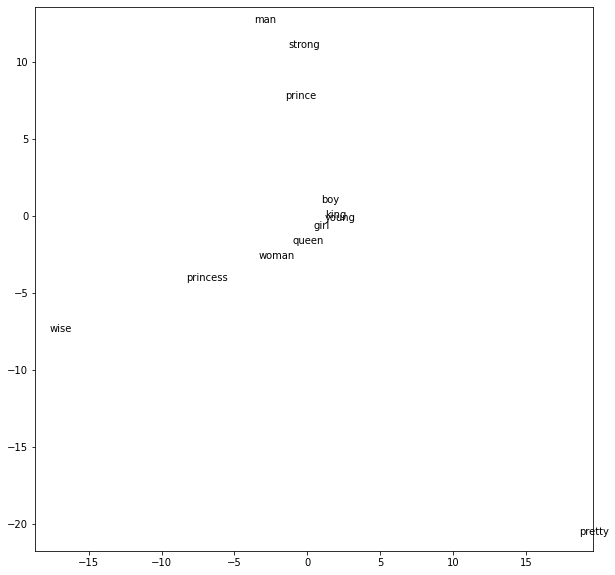

In [ ]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = list(words)
w2v_df = w2v_df[['word', 'x1', 'x2']]
print(w2v_df)
# -------------------------------------------------------------------------------------
fig, ax = plt.subplots()
for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

**Section 5: Recurrent Neural Networks** <a name="sec5"></a>



---

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment1.png?raw=1)

In [ ]:
import torch
from torch import nn
from transformers import AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.nn.functional import one_hot

We will start this session by defining a tokenization. Having discussed the pros and cons of word and character-level tokenization, it is appropriate that we start with a subword tokenization. While we could create our own subword tokenization, there are many pretrained tokenizations that can be used. We use the "bert-base-uncased" since it is fairly standard and since we expect sentiment to be unaffected by case, we want an uncased tokenization.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenize = lambda x:tokenizer.encode_plus(x['text'], truncation="only_first", return_tensors = "pt", padding='do_not_pad', max_length=512)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

We will make use of the dataset functionalility by applying the map function to the dataset, which, according to the function above, will truncate the response to the first 512. 

In [ ]:
train_data = load_dataset("imdb", split="train")
test_data = load_dataset("imdb", split="test")
token_train_data = train_data.map(tokenize).shuffle()
token_test_data = test_data.map(tokenize).shuffle()

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

We wish to set up all our parameters in an easily accessible way, so we instantiate an object and simply assign all our variables of interest, such as the dimension of the embedding, the number of hidden units, all in one object. 

In [ ]:
class configuration():
  pass
  
config = configuration
config.num_tokens = 30000
config.embedding_dim = 32
config.hidden_units = 64
config.num_layers = 2
config.dropout = 0.1
config.lr = 1e-4

Our LSTM model will be very simple as it will consist of an embedding, a recurrent layer and a linear layer. 

In [ ]:
class LSTMClassifier(nn.Module):

  def __init__(self, config):
    super(LSTMClassifier, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=config.num_tokens,
                                  embedding_dim=config.embedding_dim)
    self.rnn = nn.LSTM(input_size = config.embedding_dim,
                       num_layers = config.num_layers,
                       hidden_size = config.hidden_units,
                       dropout = config.dropout,
                       batch_first = True)
    self.classifier = nn.Linear(in_features = config.hidden_units,
                                out_features = 2)
    self.activation = nn.Softmax(1)
  
  def forward(self, model_input):
    emb = self.embedding(model_input)
    lstm_out, _ = self.rnn(emb)
    features = lstm_out[:,-1,:]
    output = self.classifier(features)
    return self.activation(output)

In [ ]:
model = LSTMClassifier(config)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
critereon = nn.MSELoss()

targets = [torch.tensor([[1.0,0.0]]),torch.tensor([[0.0,1.0]])]

In [ ]:
qbar = tqdm(token_train_data)
for x in qbar:
  optimizer.zero_grad()
  y_pred = model(torch.tensor(x['input_ids']))
  y = targets[x['label']]  

  loss = critereon(y_pred, y)
  loss.backward()
  optimizer.step()
  qbar.desc=str(loss)

One of the problems with designing an LSTM in this way is that we ideally want to train the model in batches, each of which will be a different size. The most important state for the LSTM in terms of classification will be the LSTMs effect on the last token, which should hold information stored from the start of the text to the end. If we were to pad responses to the same size, we would be interpreting the LSTMs effect on padding values.

As a consequence, the above code trains the LSTM one text at a time. The method still works, however, it is not ideal. To correct this, we can use special functionality of pytorch call pad-packed-sequences and pack-pad-sequences, which has the effect of preventing the unrolling of a recurrent network beyond the length of the text. 

Once the model is trained, we apply it to the data noting that in order to get our prediction, we are determining the highest probability class with an application of argmax.

In [ ]:
qbar = tqdm(token_test_data)

targets = []
preds = []

for x in qbar:
  targets.append(x['label'])
  preds.append(int(model(torch.tensor(x['input_ids'])).argmax(-1)))
  qbar.desc = str(accuracy_score(targets,preds))

A previous run gave me an accuracy of 89.0%, a QWK of 0.781, and an SMD of 0.046.

It is worth mentioning that there are many things we could do here such as 

*   Make the LSTM bidrectional.
*   Use pad-packed-sequences and pack-pad-sequences so that the LSTM can operate on larger batch sizes.
*   Use attention after the LSTM. 


In [ ]:
class LSTMPredictor(nn.Module):

  def __init__(self, config):
    super(LSTMPredictor, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=config.num_tokens,
                                  embedding_dim=config.embedding_dim)
    self.rnn = nn.LSTM(input_size = config.embedding_dim,
                       num_layers = config.num_layers,
                       hidden_size = config.hidden_units,
                       dropout = config.dropout,
                       batch_first = True)
    self.decoder = nn.Linear(in_features = config.hidden_units,
                                out_features = config.num_tokens)
    self.activation = nn.Softmax(1)
  
  def forward(self, model_input):
    emb = self.embedding(model_input)
    lstm_out, _ = self.rnn(emb)
    output = self.decoder(lstm_out)
    return self.activation(output)

The instantiation of the model is the same:

In [ ]:
model = LSTMPredictor(config)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
critereon = nn.MSELoss()

The main difference is that the data that goes in is the input sequence up to the second last token, while the targets are the shifted tokens. 

In [ ]:
qbar = tqdm(token_train_data)
for x in qbar:
  optimizer.zero_grad()
  input_sequence = torch.tensor(x['input_ids'][0][:-1])
  target_sequence = torch.tensor(x['input_ids'][0][1:])
  X = input_sequence.unsqueeze(0)
  Y = one_hot(target_sequence, num_classes=30000).unsqueeze(0)
  Y_pred = model(X)
  loss = critereon(Y_pred, Y.float())
  loss.backward()
  optimizer.step()
  qbar.desc=str(loss)

To simplify the generation of the next word, we simply choose the highest probability word in accordance with the model outputs. This can be done using the argmax.

In [ ]:
def next_word(text):
    model.eval()
    input_ids = tokenizer.encode(text, truncation="only_first", return_tensors = "pt", padding='do_not_pad', max_length=512)
    X = input_ids[0][:-1].unsqueeze(0)
    with torch.no_grad():
        Y_pred = model(X)
        Y_pred = Y_pred.cpu()
    return tokenizer.decode([Y_pred.argmax(-1)[0][-1]])
next_word("after careful consideration, i think i might")

'himalayan'

The training needs to be done for a long time to get good results. Preferably on a GPU. The training of an LSTM to predict words is much more difficult than the training for a classification into a small number of classes. 

**Questions**

1.   E

---
---
---

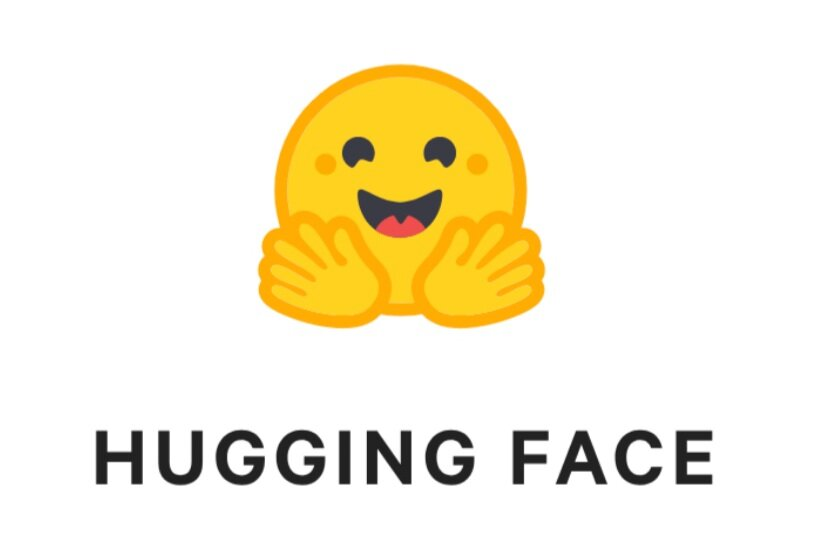

**Section 6: Language Models I** <a name="sec6"></a>


---

Huggingface is a rapidly evolving library with functions that make it easy to apply and fine-tune a variety of pretrained transformer based language models.

The libraries we will require for this section are imported below.

In [ ]:
from transformers import (AutoTokenizer,
                          pipeline,
                          AutoModelForSequenceClassification,
                          Trainer,
                          TrainingArguments)
from datasets import load_dataset
import torch
from sklearn.metrics import (accuracy_score, 
                             cohen_kappa_score)
import numpy as np

smd = lambda x,y: np.abs(np.mean(x) - np.mean(y))/np.sqrt((np.std(x)**2+np.std(y)**2)/2)

---

We start with the fact that the BERT model is trained as a masked language model. Given a text, the training involves masking approximately 15% of all the word and allowing BERT to guess the words that have been masked. The structure of this model is a transformer-based model with a linear head. The linear head determines the word that has been masked. We can access pretrained models using the Huggingface pipeline:

In [ ]:
unmasker = pipeline("fill-mask", model="bert-base-uncased")
clear_output()

In [ ]:
unmasker("This session will teach you all about [MASK] models.", top_k=3)

[{'score': 0.19930192828178406,
  'sequence': 'this session will teach you all about role models.',
  'token': 2535,
  'token_str': 'role'},
 {'score': 0.10723812133073807,
  'sequence': 'this session will teach you all about your models.',
  'token': 2115,
  'token_str': 'your'}]

We can easily experiment with different questions to gauge the accuracy of the masked language model. It also exposes some fundemantal bias in the training data. For example, 

In [ ]:
unmasker("This man works as a [MASK] .", top_k=3)

In [ ]:
unmasker("This woman works as a [MASK].", top_k=3)

In [ ]:
question_answerer = pipeline("question-answering")
clear_output()

In [ ]:
question_answerer(
    question="Where do I work?",
    context="My name is Amir and I work at CL in in District of Columbia office.")

{'answer': 'CL in in District of Columbia office',
 'end': 66,
 'score': 0.4350461959838867,
 'start': 30}

In [ ]:
ner = pipeline("ner", grouped_entities=True)
clear_output()

In [ ]:
ner("My name is Amir and I work at CL in District of Columbia office.")

In [ ]:
generator = pipeline("text-generation", model="distilgpt2")
clear_output()

In [ ]:
generator(
    "In this session, we will teach you how to",
    max_length=30,
    num_return_sequences=2)

Pretrained networks can be a useful structure, in fact

In [ ]:
sentiment = pipeline("sentiment-analysis","textattack/distilbert-base-uncased-imdb", truncation="only_first")
clear_output()

In [ ]:
sentiment("It was the worst experience of my life.")

[{'label': 'LABEL_0', 'score': 0.997365415096283}]

In [ ]:
sentiment("I had the time of my life.")

[{'label': 'LABEL_1', 'score': 0.9255179762840271}]

In [ ]:
train_data = load_dataset("imdb", split="train")
test_data = load_dataset("imdb", split="test")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


In [ ]:
from tqdm import tqdm
preds = [sentiment(x['text']) for x in tqdm(test_data)]
targets = [x['label'] for x in test_data]


 20%|█▉        | 4957/25000 [42:38<3:29:18,  1.60it/s]

KeyboardInterrupt: ignored

The accuracy for this model (after 3 hours of computation) is 92.44% and a QWK of 0.849. It is clearly superioir to the BoW model and the LSTM. 

---

When setting up a model to do autoscoring, we are required to take our own dataset of scored responses and fine-tune it to a particular problem. The process of fine-tuning a model to do sequence classification will take a lot more computing power than what would be allowed in a Colab notebook. So while we will not complete the training here, we will outline the process. 

Firstly, we need to define the neural-network architecture. For the example below, due to the colab notebooks constraints on RAM, we will only try to fine-tune a model with only 4 hidden layers layers. So the neural network architecture is specified by the pretrained type, and the number of layers we want to assign to perform the calculations:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_hidden_layers=4)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenize = lambda x:tokenizer.encode_plus(x['text'], truncation="only_first", return_tensors = "pt", padding='max_length', max_length=512)
clear_output()

To make things simple, we use the map functionality of the dataset class and apply it to the train-test split for the imdb dataset. We also shuffle the dataset because the original format of the dataset orders the data with respect to their labels which can make training more difficult. 

In [ ]:
train_data = load_dataset("imdb", split="train")
test_data = load_dataset("imdb", split="test")
token_train_data = train_data.map(tokenize).shuffle()
token_test_data = test_data.map(tokenize).shuffle()
clear_output()

While there are many ways to implement this procedure, we have chosen to write our own collator, which takes a batch of data, which is a list of elements from our dataset, and combines the batch into a single input. The input contains everything required of the model; input ids, an attention mask, and token type ids, which are all supplied by the tokenizer at an individual text level, but the collator combines these by stacking them together.

In [ ]:
def collator(batch):
  input_ids = torch.tensor([x['input_ids'][0] for x in batch])
  attention_mask = torch.tensor([x['attention_mask'][0] for x in batch])
  token_type_ids = torch.tensor([x['token_type_ids'][0] for x in batch])
  labels = torch.tensor([x['label'] for x in batch])
  return {"input_ids":input_ids,
          "attention_mask":attention_mask,
          "token_type_ids":token_type_ids,
          'labels':labels}
  

Once the collator is defined, the Trainer has many arguments, which one can look up [here](https://huggingface.co/docs/transformers/main_classes/trainer), however to simplify things, we will only specify one parameter; the batch size, which is required to be sufficiently small to fit into the memory allowed by the notebook.

In [ ]:
args = TrainingArguments(output_dir="tmp",
                         per_device_train_batch_size=2,
                         per_device_eval_batch_size=2)
trainer = Trainer(model,
                  args, 
                  data_collator = collator,
                  train_dataset = token_train_data)
trainer.train()

---
---
---

**Excercises**



**References**

1.   Alikaniotis, Dimitrios, Helen Yannakoudakis, and Marek Rei. "Automatic text scoring using neural networks." arXiv preprint arXiv:1606.04289 (2016).
1.   Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio. "Neural machine translation by jointly learning to align and translate." arXiv preprint arXiv:1409.0473 (2014).
1.   Burkhardt, Amy Katrina, Susan Lottridge, Sherri Woolf, and Chris Ormerod. "Defining At-Risk Student Responses."
1.   Devlin, Jacob, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).
1.   Dong, Fei, Yue Zhang, and Jie Yang. "Attention-based Recurrent Convolutional Neural Network for Automatic Essay Scoring." In CoNLL, pp. 153-162. 2017.
1.   Harris, Zellig S. "Distributional structure." Word 10, no. 2-3 (1954): 146-162.
1.   Hochreiter, Sepp, and Jürgen Schmidhuber. "Long short-term memory." Neural computation 9, no. 8 (1997): 1735-1780.
1.   James, Frankie. "Modified kneser-ney smoothing of n-gram models." Research Institute for Advanced Computer Science, Tech. Rep. 00.07 (2000).
1.   Ormerod, Christopher. "Short-answer scoring with ensembles of pretrained language models." arXiv preprint arXiv:2202.11558 (2022).
1.   Ormerod, Christopher M., Akanksha Malhotra, and Amir Jafari. "Automated essay scoring using efficient transformer-based language models." arXiv preprint arXiv:2102.13136 (2021).
1.   Ormerod, Christopher M., and Amy E. Harris. "Neural network approach to classifying alarming student responses to online assessment." arXiv preprint arXiv:1809.08899 (2018).
1.   Ormerod, Christopher, Amir Jafari, Susan Lottridge, Milan Patel, Amy Harris, and Paul van Wamelen. "The effects of data size on Automated Essay Scoring engines." arXiv preprint arXiv:2108.13275 (2021).
1.   Řehůřek, Radim, and Petr Sojka. "Gensim—statistical semantics in python." Retrieved from genism. org (2011).
1.   Taghipour, Kaveh, and Hwee Tou Ng. "A neural approach to automated essay scoring." In Proceedings of the 2016 conference on empirical methods in natural language processing, pp. 1882-1891. 2016.
1.   Rodriguez, Pedro Uria, Amir Jafari, and Christopher M. Ormerod. "Language models and automated essay scoring." arXiv preprint arXiv:1909.09482 (2019).
1.   Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. "Attention is all you need." Advances in neural information processing systems 30 (2017).

